# Homework 6.2 - Neural Networks and Deep Learning

**Name**: Sara Rajabzadeh

**Student Number**:

**Sources**:

An [AutoEncoder](https://en.wikipedia.org/wiki/Autoencoder#:~:text=An%20autoencoder%20is%20a%20type,to%20ignore%20signal%20%E2%80%9Cnoise%E2%80%9D.) (AE) is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. Despite their numerous applications their implemention and theoretical background is pretty straightforward. Throughout this assignment you will implement an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron)-based AE to reconstruction hand-written digits of [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. 

### Install & import the required packages
Install and import torch and torchvision (or any other package you think might come in handy).

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import torchvision.datasets

### 0. Load input data and preprocess (3 pt)
You're expected to use the MNIST dataset over the course of this assignment. After loading the train and test splits of the dataset, apply the required preprocessing procedures (zero center your input data). PyTorch provides convenient tools to automate this process.

In [5]:
trainD = pd.read_csv("mnist_train.csv")
print(trainD.shape)
X_train, X_test, Y_train, Y_test = train_test_split(trainD.iloc[:,1:], trainD.iloc[:,0],test_size=1/20, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


# transform = transforms.Compose([transforms.ToTensor(),
#                               transforms.Normalize((0.5,), (0.5,)),
#                               ])
# trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True)
# validset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# valloader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)

(59999, 785)
(56999, 784)
(56999,)
(3000, 784)
(3000,)


In [22]:
class DatasetMNIST(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X.index)

  def __getitem__(self, idx):
    img = torch.tensor(self.X.iloc[idx,].values, dtype=torch.float32)
    return img, self.y.iloc[idx]


In [23]:
train_dataset = DatasetMNIST(X=X_train, y=Y_train)
test_dataset = DatasetMNIST(X=X_test, y=Y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

### 1.1. Implement an MLP based Autoencoder (17 pt)
The architecture of your network should be symmetrical and have 2 hidden layers of sizes $h_1$ and $h_2$ with a latant size of $l$ while using [$ReLU$](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))s as nonlinearities. The following picture depicts a sample AE architecture for $h_1=4$ and $h_2=3$ and $l=2$ for the reconstruction of $1\times5$ inputs.

<img src="./ae.png">

The input to the network will be a minibatch of data, of shape
$(N, 28*28)$ where $N$ represents batch size. 

    Inputs of the forwardpass:
    - A batch of flated images (N, 28*28)

    outputs of the forwardpass:
    - reconstruction: reconstruction of the images.

In [24]:
class MLP_MNIST(nn.Module):
  def __init__(self, **kwargs):
    super().__init__()

    self.layers = nn.Sequential(nn.Linear(kwargs["inp"], kwargs["h1"]),
                      nn.ReLU(),
                      nn.Linear(kwargs["h1"],kwargs["h2"]),
                      nn.ReLU(),
                      nn.Linear(kwargs["h2"], kwargs["l"]),
                      nn.ReLU(),
                      nn.Linear(kwargs["l"], kwargs["h2"]),
                      nn.ReLU(),
                      nn.Linear(kwargs["h2"], kwargs["h1"]),
                      nn.ReLU(),
                      nn.Linear(kwargs["h1"], kwargs["inp"]),
                      nn.ReLU())



    
  def forward(self,X):
    X = self.layers(X)
    return X


### 1.2. Train the model (17 pt)
Set up a basic training loop for your network. Use a [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with no momentums to train your model. Use [L2](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions) as your objective function. Choose $N$ based on your available resources. (8 pt)

In [32]:
model = MLP_MNIST(inp=28*28, h1=512, h2=256, l=5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [33]:
mean_train_loss = []
mean_test_loss = []
test_acc_list = []
epochs = 15


Train a model with $h_1=512$, $h_2=256$ and $l=5$, Train your model long enough so that you get the best results on the validation set. (2 pt)

In [34]:

for epoch in range(epochs):
  model.train()
  train_losses = []
  test_losses = []

  for i, (images,labels) in enumerate(train_loader):
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    # loss = loss.type(torch.LongTensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for i, (images,labels) in enumerate(test_loader):
      outputs = model(images)
      loss = loss_fn(outputs, labels)

      test_losses.append(loss.item())

      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  mean_train_loss.append(np.mean(train_losses))
  mean_test_loss.append(np.mean(test_losses))

  accuracy = correct/total*100
  test_acc_list.append(accuracy)
  print(f'epoch: {epoch}, train_loss: {np.mean(train_losses):.2f}, test_loss: {np.mean(test_losses):.2f}, valid_acc: {accuracy:.2f}')

epoch: 0, train_loss: 3.08, test_loss: 2.44, valid_acc: 60.17
epoch: 1, train_loss: 2.31, test_loss: 2.25, valid_acc: 64.87
epoch: 2, train_loss: 2.20, test_loss: 2.19, valid_acc: 66.37
epoch: 3, train_loss: 2.15, test_loss: 2.19, valid_acc: 65.87
epoch: 4, train_loss: 2.13, test_loss: 2.15, valid_acc: 67.00
epoch: 5, train_loss: 2.10, test_loss: 2.14, valid_acc: 67.00
epoch: 6, train_loss: 2.09, test_loss: 2.13, valid_acc: 67.23
epoch: 7, train_loss: 2.07, test_loss: 2.12, valid_acc: 67.40
epoch: 8, train_loss: 2.06, test_loss: 2.12, valid_acc: 67.43
epoch: 9, train_loss: 2.05, test_loss: 2.12, valid_acc: 67.60
epoch: 10, train_loss: 1.93, test_loss: 1.49, valid_acc: 76.27
epoch: 11, train_loss: 1.43, test_loss: 1.44, valid_acc: 77.23
epoch: 12, train_loss: 1.40, test_loss: 1.44, valid_acc: 77.50
epoch: 13, train_loss: 1.39, test_loss: 1.44, valid_acc: 77.03
epoch: 14, train_loss: 1.38, test_loss: 1.43, valid_acc: 77.40


Plot the mean objective values for training and validation set on each epoch. (2 pt)

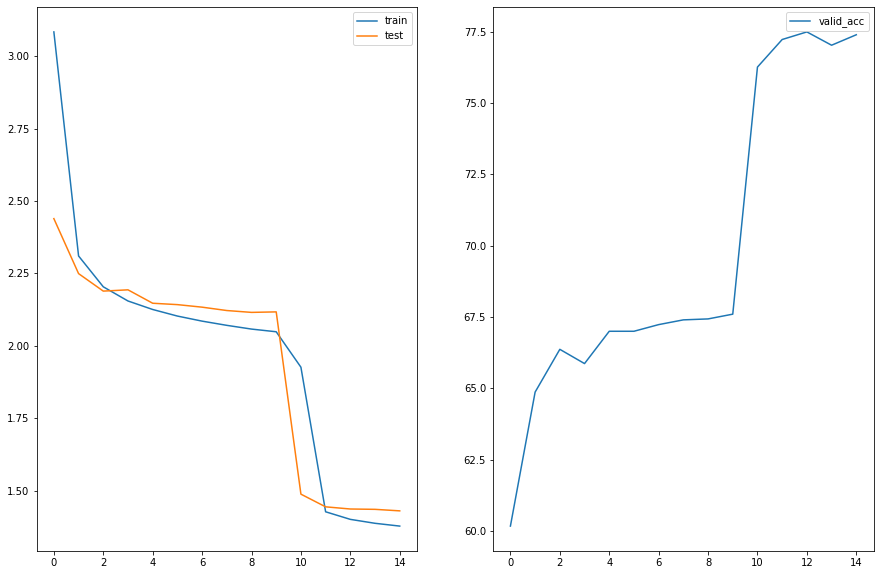

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax1.plot(mean_train_loss,label = "train")
ax1.plot(mean_test_loss,label = "test")
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc = "best")

ax2.plot(test_acc_list, label= "valid_acc")
ax2.legend()

Visualize the best and worst reconstructions of test split. (3 pt)

Elaborate on how larger batchsizes can affect the training procedure and the final performance of the model? (2 pt)

افزایش این مقدار تا حدودی میتواند به کارایی مدل کمک کند اما در صورتی که این سایز خیلی افزایش یابد دیگر مدل ما نمیتواند خوب تعمیم دهد بنابراین افزایش آن از یه حدی به بعد میتواند به شدت کارایی را کاهش دهد

### 1.3. Investigation of different Latent sizes (14 pt)
By training your AE for $l=1$ to $l=7$ and visualizing the final train and validation reconstruction errors and sample outputs (for a fixed input), investigate the effects of lower and higher encoding latent spaces. (8 pt)

In [44]:
ls = []
for j in range(1,8):
  model = MLP_MNIST(inp=28*28, h1=512, h2=256, l=j)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
  loss_fn = nn.CrossEntropyLoss()
  for epoch in range(epochs):
    model.train()
    train_losses = []
    test_losses = []

    for i, (images,labels) in enumerate(train_loader):
      outputs = model(images)
      loss = loss_fn(outputs, labels)
      # loss = loss.type(torch.LongTensor)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for i, (images,labels) in enumerate(test_loader):
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        test_losses.append(loss.item())

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    mean_train_loss.append(np.mean(train_losses))
    mean_test_loss.append(np.mean(test_losses))
    ls+=[j]

    accuracy = correct/total*100
    test_acc_list.append(accuracy)
    print(f'l: {j}, epoch: {epoch}, train_loss: {np.mean(train_losses):.2f}, test_loss: {np.mean(test_losses):.2f}, valid_acc: {accuracy:.2f}')
    

l: 1, epoch: 0, train_loss: 3.70, test_loss: 3.52, valid_acc: 10.90
l: 1, epoch: 1, train_loss: 3.36, test_loss: 3.35, valid_acc: 24.63
l: 1, epoch: 2, train_loss: 3.21, test_loss: 3.24, valid_acc: 22.30
l: 1, epoch: 3, train_loss: 3.10, test_loss: 3.11, valid_acc: 29.73
l: 1, epoch: 4, train_loss: 2.99, test_loss: 3.06, valid_acc: 33.87
l: 1, epoch: 5, train_loss: 2.90, test_loss: 2.99, valid_acc: 38.23
l: 1, epoch: 6, train_loss: 2.83, test_loss: 2.92, valid_acc: 39.67
l: 1, epoch: 7, train_loss: 2.76, test_loss: 2.89, valid_acc: 39.13
l: 1, epoch: 8, train_loss: 2.72, test_loss: 2.87, valid_acc: 42.53
l: 1, epoch: 9, train_loss: 2.67, test_loss: 2.83, valid_acc: 43.80
l: 1, epoch: 10, train_loss: 2.63, test_loss: 2.80, valid_acc: 43.63
l: 1, epoch: 11, train_loss: 2.60, test_loss: 2.86, valid_acc: 41.40
l: 1, epoch: 12, train_loss: 2.56, test_loss: 2.77, valid_acc: 45.07
l: 1, epoch: 13, train_loss: 2.54, test_loss: 2.75, valid_acc: 45.03
l: 1, epoch: 14, train_loss: 2.51, test_loss

Elaborate on how the increase of the latent size of the AE will affect the quality of the reconstructed images and why? (3 pt)

همان طور که در بالا مشخص است افزایش این مقدار میتواند تا حدودی موثر باشد و کارایی را افزایش دهد اما هنگامی که آن را ۷ قرار دادیم کارایی کاهش پیدا کرد زیرا اگر این مقدار کوچک باشد نمیتوان به خوبی اطلاعات رمزگذاری شده را رمزگشایی کرد زیرا ممکن است اطلاعاتی ا ناخواسته از دست بدهیم و اما اگر این مقدار زیاد باشد ممکن است ازاطلاعات نه چندان خوبی را وارد آن کنیم که کیفیت کار از دست برود.

Elaborate on how the increase of the latent size of the AE will affect its training time? (3 pt)

باعث افزایش آن میشود. زیرا هر چقدر زیاد شود تعداد خصیصه های لازم برای آموزش داده ها افزایش می یابد و در نهایت زمان آموزش بیشتر خواهد شد

### 2. AE as a dimensionality reduction tool (14 pt)
Plot the respective latent vectors of the validation images after training an AE with $l=2$. (10 pt)

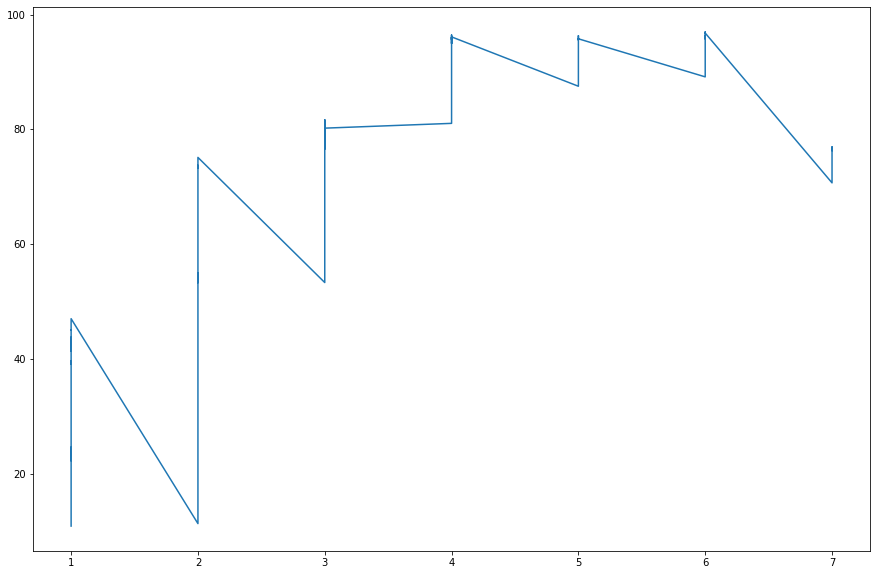

In [48]:
fig,ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
ax1.plot(ls,test_acc_list[30:],label = "test")

Elaborate on why you see what you see!? (2 pt)

<div dir="rtl">همانطور که مشخص است و در بالا نیز اشاره شد تا جایی افزایش l به کیفیت کمک میکند اما از جایی به بعد از کیفیت آن میکاهد زیرا خصیصه هایی را به درد نمیخورد وارد کار می شوند و این باعث می شود که کیفیت تصویر خوب نشود.</div>

Describe how AEs can be used as a visualization tool (like PCA algorithm). (2 pt)

<div dir="rtl"></div>